# Sentiment Rateability

Prototype code for binary Classifier, which should discriminate between non- & rateable Social Media Posts/Comments for Sentiment assignment. 

In [1]:
import os, re, string, pickle, random

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename columns uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove duplicated texts (n=71)
labeled_data.drop_duplicates(subset="text", keep="first", inplace=True)

# Remove not assessable and offensive texts
labeled_data["rateable"] = np.where(labeled_data.rating == -2, 0, 1)

labeled_data.shape

(1271, 4)

Text cleansing

In [5]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Split emojis away from words
    > Stopwords removal
    > Stemming
    > Removes single characters
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    split_emoji = emoji.get_emoji_regexp().split(num_replaced) # splits emoji from words away
    tokenized = word_tokenize(" ".join(split_emoji)) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join([word for word in stemmed if len(word) > 1])
    
    return cleaned_txt

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [6]:
labeled_data.isna().sum()

source         0
text           0
rating         0
rateable       0
cleaned_txt    0
dtype: int64

Duplicated texts (after cleaning)

In [7]:
labeled_data.text.duplicated().value_counts()

False    1271
Name: text, dtype: int64

Distribution of rateability

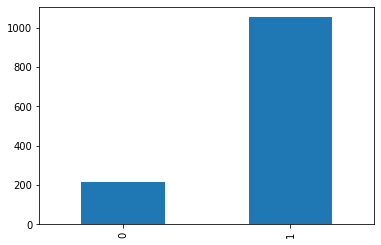

In [8]:
labeled_data.rateable.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced (and generally too less) data.

## Binary Classification

ML-based approach.

### Train/Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rateable,
                                                    test_size=0.20, stratify=labeled_data.rateable,
                                                    random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (1016,) / (255,)
y shapes (train/test): (1016,) / (255,)


### Vectorizer

In [10]:
count_vect = CountVectorizer(lowercase=False, # already lowercased
                             tokenizer=word_tokenize,
                             #ngram_range=(1,2),
                             max_features=4000) # tune max_features for generalization eventually, 3gram 25k, 2gram 10k

tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize,
                        #ngram_range=(1,3),
                        max_features=4000) # tune max_features for generalization eventually

### Models

In [11]:
logreg = LogisticRegression(solver="saga", max_iter=4000, random_state=random_state, n_jobs=1)
svc = LinearSVC(random_state=random_state)
nb = MultinomialNB()

models = [logreg, svc, nb]

Parameters

In [12]:
params = {}
params["LogisticRegression"] = {"penalty": ["l1", "l2"],
                                "C": [0.01, 0.1, 1., 10.,30., 60.],
                                "class_weight": ["balanced"]}
params["LinearSVC"] = {"C": [0.01, 0.1, 1., 10., 20.],
                       "class_weight": ["balanced"]}
params["MultinomialNB"] = {"alpha": [1.0e-10, 1.],
                           "fit_prior": [True, False]}

### Pipeline

In [13]:
classifiers = {}
scoring = "precision"

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        #("count_vect", count_vect),
        ("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring=scoring, cv=8, refit=True, n_jobs=-1))
    ])

Train

In [14]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score

In [15]:
best_score = 0
best_model_pipe = None # = best generalization

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    scores = cross_validate(clf_pipeline, X_test, y_test, scoring=scoring, cv=8, n_jobs=1)
    mean_score = scores["test_score"].mean()
    mean_fit_time = scores["fit_time"].mean()
    
    print(name)
    print("Test score (mean):", mean_score)
    print("Test fit time (mean):", mean_fit_time)
    print("Train score:", clf_pipeline.named_steps["clf"].best_score_)
    print("Params:", clf_pipeline.named_steps["clf"].best_params_, "\n")
    
    if mean_score > best_score:
        best_model_pipe = clf_pipeline
        best_score = mean_score

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression_pipe
Test score (mean): 0.8262182021028657
Test fit time (mean): 10.43346980214119
Train score: 0.89045751648049
Params: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1'} 

LinearSVC_pipe
Test score (mean): 0.8335613479262672
Test fit time (mean): 0.16618627309799194
Train score: 0.8747856774748971
Params: {'C': 20.0, 'class_weight': 'balanced'} 

MultinomialNB_pipe
Test score (mean): 0.8611404463218979
Test fit time (mean): 0.09545838832855225
Train score: 0.8673915589346374
Params: {'alpha': 1.0, 'fit_prior': False} 



In [16]:
#len(best_model_pipe.named_steps["tfidf"].get_feature_names())

## Evaluation

In [17]:
print("Best pipeline CLF:", best_model_pipe.named_steps["clf"].best_estimator_)

Best pipeline CLF: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)


In [18]:
class_encoding = {0: "non-rateable", 1: "rateable"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


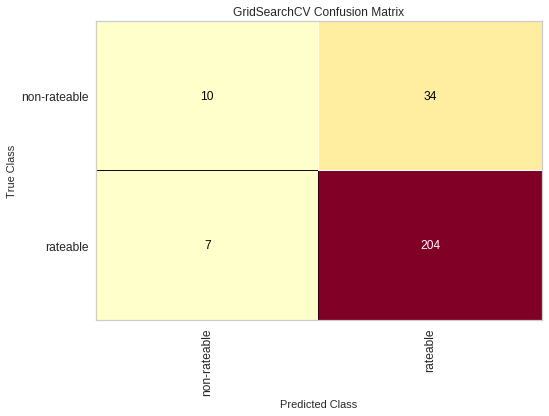

In [19]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

           0       0.59      0.23      0.33        44
           1       0.86      0.97      0.91       211

    accuracy                           0.84       255
   macro avg       0.72      0.60      0.62       255
weighted avg       0.81      0.84      0.81       255



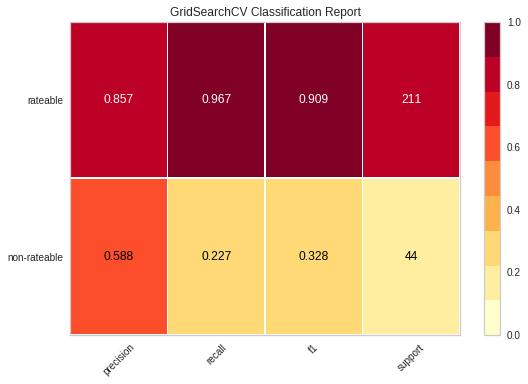

In [20]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

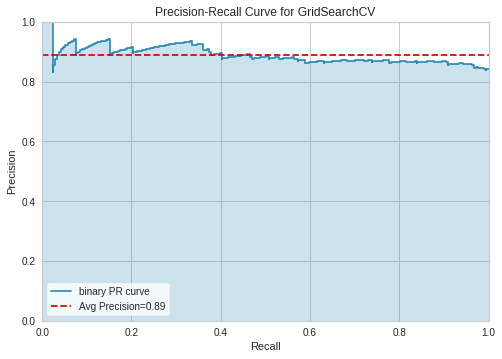

In [21]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

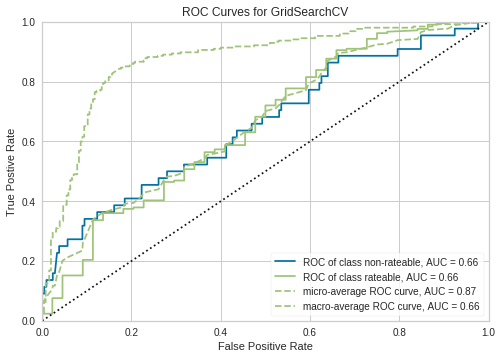

In [22]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

Binary classifier performs still too bad for non-rateable Posts/Comments. If its Recall can enhanced slightly (>0.5) production use can be considered.